# 🏥 Healthcare Data Predictive Analysis

## 📌 Project Overview
This project applies machine learning techniques to predict the likelihood of a stroke based on patient demographic and medical data. It demonstrates proficiency in data preprocessing, exploratory data analysis (EDA), classification modeling, hyperparameter tuning, model evaluation, explainability, and production-readiness—all essential skills for data science and machine learning roles.

## 🎯 Objectives
- Load and clean the dataset
- Perform exploratory data analysis (EDA)
- Encode and engineer features
- Train and compare multiple machine learning models
- Apply hyperparameter tuning with GridSearchCV
- Evaluate model performance with classification metrics and AUC
- Interpret model insights and explainability with SHAP
- Prepare for production deployment

## 📊 Dataset Description
- **Source**: [Kaggle - Stroke Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)
- **Rows**: 5110 patient records
- **Features**: Gender, age, hypertension, heart disease, marital status, work type, residence type, glucose level, BMI, smoking status, and stroke outcome.
- **Target**: `stroke` — whether the patient had a stroke or not.

In [123]:
!pip install lightgbm
!pip install shap
!pip install xgboost
!pip install imbalanced-learn
!pip install scikit-learn==1.6.1

  Using cached scikit_learn-1.6.1-cp312-cp312-macosx_12_0_arm64.whl.metadata (31 kB)
Using cached scikit_learn-1.6.1-cp312-cp312-macosx_12_0_arm64.whl (11.2 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import joblib
import shap
import warnings
warnings.filterwarnings("ignore")

In [125]:
file_path = 'Copy of heart_attack_prediction_dataset.csv'
df = pd.read_csv(file_path)

In [126]:
# Feature engineering: split Blood Pressure
df[['Systolic_BP', 'Diastolic_BP']] = df['Blood Pressure'].str.split('/', expand=True).astype(int)
df.drop(columns=['Patient ID', 'Blood Pressure'], inplace=True)

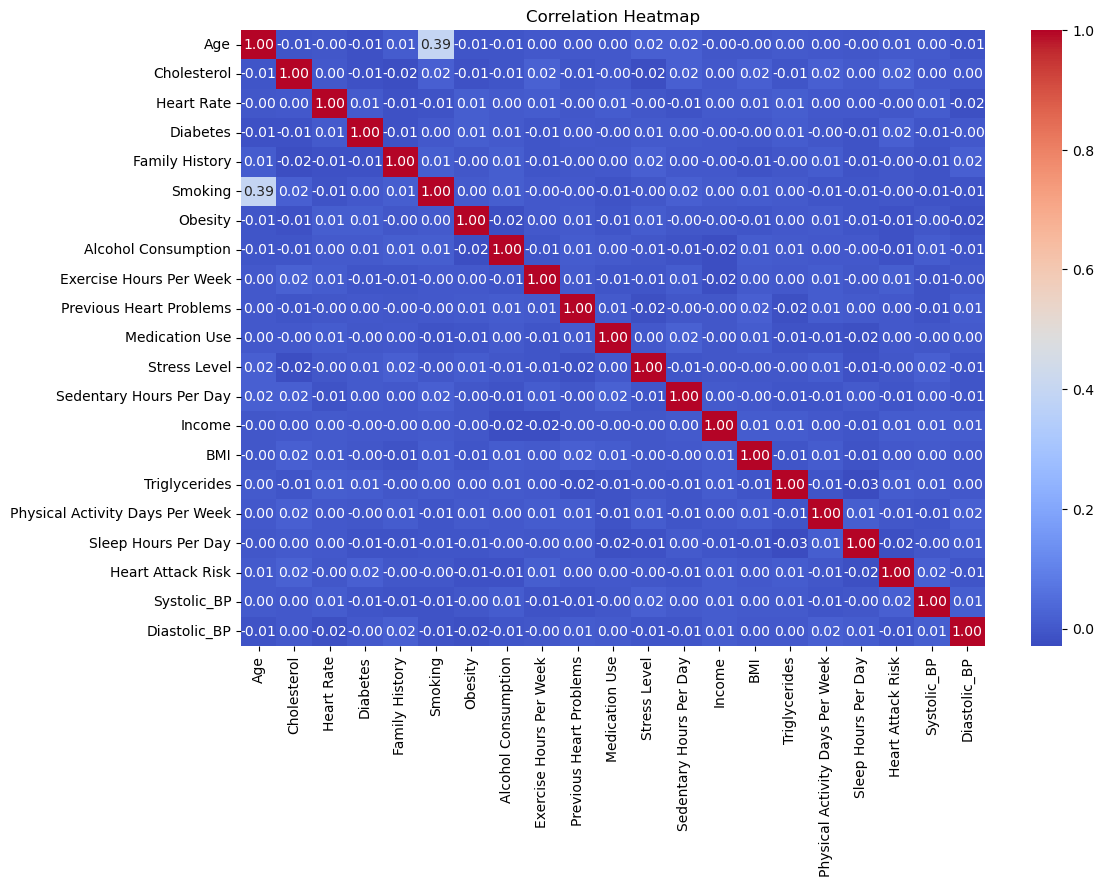

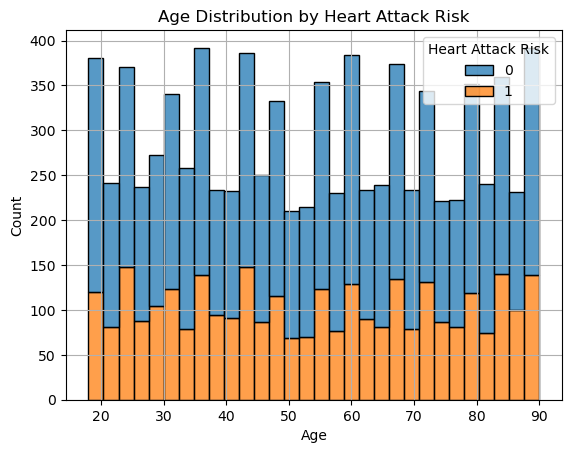

In [127]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Age vs Heart Attack Risk
sns.histplot(data=df, x='Age', hue='Heart Attack Risk', multiple='stack', bins=30)
plt.title('Age Distribution by Heart Attack Risk')
plt.xlabel('Age')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [128]:
X = df.drop(columns=['Heart Attack Risk'])
y = df['Heart Attack Risk']

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])

X_processed = preprocessor.fit_transform(X)

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.3, random_state=42, stratify=y)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [130]:
# Logistic Regression
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg.fit(X_resampled, y_resampled)

# Random Forest
rf_params = {'n_estimators': [100, 150], 'max_depth': [None, 10, 20]}
rf_model = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='f1')
rf_model.fit(X_resampled, y_resampled)

# XGBoost
xgb_params = {
    'n_estimators': [100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}
xgb_model = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), xgb_params, cv=5, scoring='f1')
xgb_model.fit(X_resampled, y_resampled)

# LightGBM
lgb_params = {
    'n_estimators': [100, 200],
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.1]
}
lgb_model = GridSearchCV(LGBMClassifier(random_state=42), lgb_params, cv=5, scoring='f1')
lgb_model.fit(X_resampled, y_resampled)

[LightGBM] [Info] Number of positive: 3149, number of negative: 3150
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7215
[LightGBM] [Info] Number of data points in the train set: 6299, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499921 -> initscore=-0.000318
[LightGBM] [Info] Start training from score -0.000318
[LightGBM] [Info] Number of positive: 3149, number of negative: 3150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7214
[LightGBM] [Info] Number of data points in the train set: 6299, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499921 -> initscore=-0.000318
[LightGB

GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42),
             param_grid={'learning_rate': [0.01, 0.1],
                         'n_estimators': [100, 200], 'num_leaves': [31, 50]},
             scoring='f1')

In [131]:
models = {
    'Logistic Regression': logreg,
    'Random Forest': rf_model.best_estimator_,
    'XGBoost': xgb_model.best_estimator_,
    'LightGBM': lgb_model.best_estimator_
}

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    report = classification_report(y_test, y_pred, output_dict=True)
    results.append([
        name,
        round(accuracy_score(y_test, y_pred), 4),
        round(report['1']['precision'], 4),
        round(report['1']['recall'], 4),
        round(report['1']['f1-score'], 4),
        round(auc, 4)
    ])

results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])
print(results_df.sort_values(by='F1 Score', ascending=False))

                 Model  Accuracy  Precision  Recall  F1 Score     AUC
0  Logistic Regression    0.5086     0.3633  0.4936    0.4185  0.5007
2              XGBoost    0.6082     0.3937  0.1730    0.2404  0.5204
3             LightGBM    0.6010     0.3781  0.1762    0.2404  0.5186
1        Random Forest    0.6231     0.3584  0.0658    0.1112  0.4916


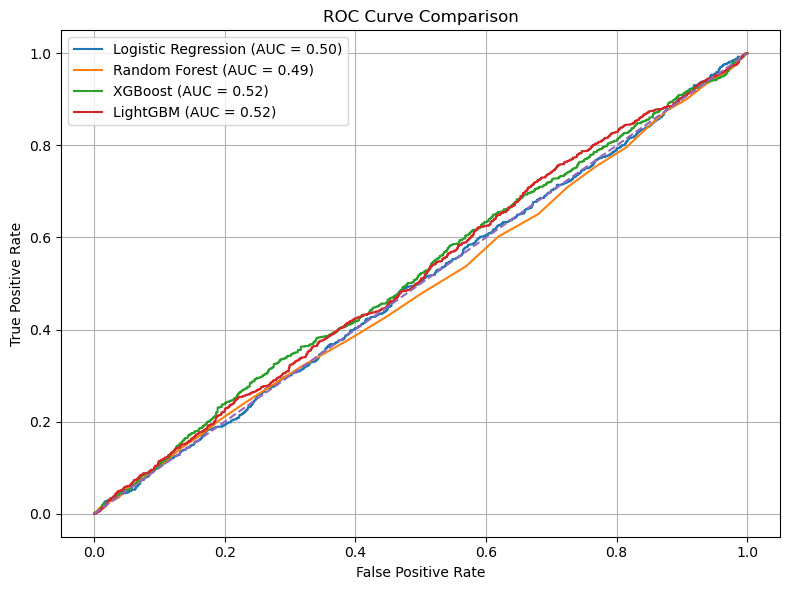

In [132]:
plt.figure(figsize=(8, 6))
for name, model in models.items():
    probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

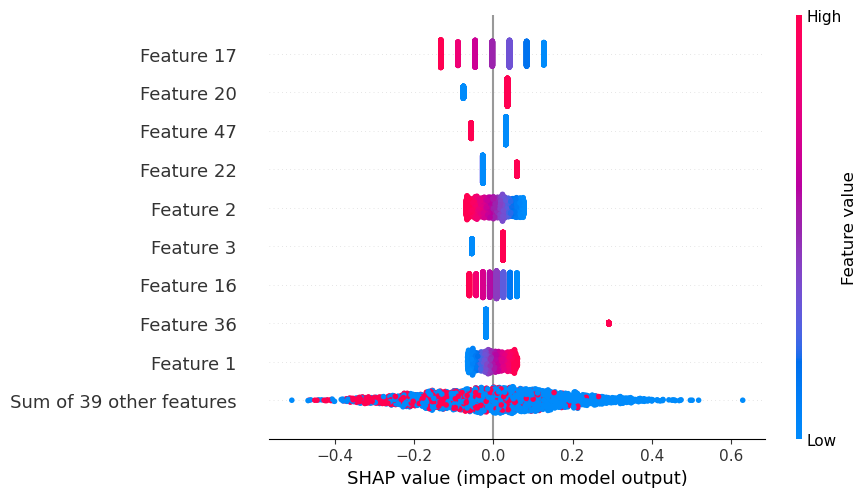

In [133]:
best_model = logreg
explainer = shap.Explainer(best_model, X_test)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

In [134]:
joblib.dump(best_model, 'heart_attack_model.pkl')
joblib.dump(preprocessor, 'heart_attack_preprocessor.pkl')
print("Trained model and preprocessor saved!")

Trained model and preprocessor saved!


In [135]:
joblib.dump(best_model, 'heart_attack_model.pkl')
joblib.dump(preprocessor, 'heart_attack_preprocessor.pkl')

['heart_attack_preprocessor.pkl']

In [136]:
from IPython.display import FileLink

# Create clickable download links
display(FileLink('heart_attack_model.pkl'))
display(FileLink('heart_attack_preprocessor.pkl'))

/Users/prishachawla/Documents/Projects /Semester 2/Data and Programming/heart_attack_model.pkl

/Users/prishachawla/Documents/Projects /Semester 2/Data and Programming/heart_attack_preprocessor.pkl